# Lecture 1: The computational real neuron. 

Welcome to the SageMaker workshop. 

## Supervised Learning.

**Supervised learning is the task of arriving at a mathematical mapping function from the co-variate space to the variate space using a labeled training dataset.** The training dataset is of a set of co-variate - variate sample mapping. In supervised learning, each example is a pair consisting of an input object (typically a vector) and a desired output value (also called the supervisory signal). Colloquially, various names are used for the co-variates and variates, the most common ones being 'features' and 'lables'.

Let us create a relatable and lower-dimensional dataset to study supervised learning. Assume that you are a human resource manager at Amazon and that we are planning to make strategic human resource expansions in your department. While mkaing great hiring decisions, we would like to know antecedently how much that candidate’s pay scale is likely to be. In today’s market where data scientists are in strong demand, most candidates have a free-market value they are predisposed to expect. As a data scientist yourself, and keeping with Amazon's tradition of relenetlessly relying on data, we could use machine learning to model a future candidate’s potential compensation. Using this knowledge, we can negotiate during the interview. 

Let us use the compensation of some of our colleagues who are already employed in the org in estimating a future employee’s pay. Say your org has $n+m$ employees who are willing to provide you their compensation data. If you create a dataset of your current employees, you may come up with something that looks like the following (considering for now only the first $n$ employees as the training data):
$$ D = \begin{bmatrix}
    \bf{x_1} & y_1 \\ 
    \bf{x_2} & y_2 \\
    \vdots & \vdots \\
    \bf{x_n} & y_n \end{bmatrix},$$
where, $\bf{x_i} \in \mathbb{R}^d$ is a d-dimensional (vector) sample where each sample represents an existing employee and each dimesnion of this sample corresponds to an attribute of the employee that is related to their compensation and $y_i \in \mathbb{R}^1$ is the salary of the respective employee. 

In this dataset, **to *learn* is to establish a mapping between the features and the labels.** To model the compensation of the employees, consider for now that, $x_i \in \mathbb{R}^1$, is a one-dimensional feature, perhaps the number of years of experience a candidate has in the field. The provided code has a data simulator that will generate some syntehtic data to mimic this scenario. The data might look like something like what is generated by the code-block below.

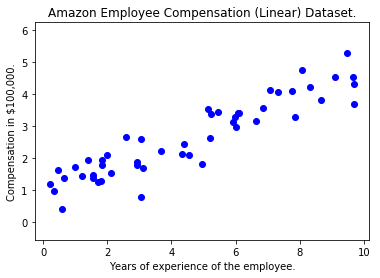

In [1]:
from dataset import dataset_generator
# Initialize a dataset creator
dataset = dataset_generator(dimensions = 1)
dataset._demo()

The dataset is created as follow:

* Consider a real line from which the dataset is supposed to be derived from.
* Add a small amount of noise to the data on the line.
* Sample from this noisy line. 

Implementationally, the class `dataset_generator` uses the following piece of code to achieve this. The class constructors, creates a `w` and `b` parameter randomly. The class also instantiates a `mu` and `sigma` for the noise generator. Instantiating these parameters helps us query from the same data distribution over and over again. 

```python 
self.w = np.random.rand(self.dimensions,1)
self.b = np.random.rand(1)
self.mu = 0
self.sigma = 0.5
```
Every time the `dataset_generator.query_method` method is callled a new `x` and `y` are sampled from this line.
```python
x = np.random.uniform(size = (samples, self.dimensions), low = 0, high = 10)        
y = np.dot(x, self.w) + np.random.normal(self.mu, self.sigma, (samples,1)) + self.b
```
Formally, Supervised learning is the process of establishing through a model, the relationship or mapping between $(\bf{x} ,y)$ using $(\bf{x_i},y_i) \in D \forall i \in [i,n]$, such that once established, given a new sample $x_{n+j} \notin D$ and $j<m$, the model estimates $y_{n+j}$. Informally, we want to learn a model using the training part of the dataset, such that we should be able to predict the associated label for samples from the remaining. The dataset $D$ is called the training dataset and the set of samples $x_i, i \in (n, n + m]$ is called the generalization dataset. The generalization dataset may also be the real world. If we have the knowledge of the actual targets of the samples in the generalization set, we call it the testing set, as we can use it to test the quality of our model before deploying it in the real world.

Models are usually of the form $\hat{y} = g(\bf{X},w)$ where, $w$ are the parameters or weights of the model that transform $X$ to $\hat{y}$. In short, a model is a functional form that was predetermined that depends on some to-be determined parameters whose values are to be learnt using the data.

## Least Squares Linear Regression.

Let us posit that the experience of the candidates and their compensation are **linearly related**. What this means is that we are making a decision that the relationship between the candidates’ experience and the salaries is captured by a straight line. With this assumption, we have are limiting the architecture of our problem to linear models and converted our problem into a linear regression problem. Essentially, if our data is $x \in \mathbb{R}^1$, then our prediction is, 
$$ \hat{y} = w_1x + b.$$
If $\bf{x} \in \mathbb{R}^d $, then 
$$ \hat{y} = \sum_{i=1}^d w_ix^i + b.$$

To know how good our predictions are we need some metric to measure our errors. Consider the root-mean-squared error or the RMSE,
$$ e_i(\bf{w}) = \vert \vert \hat{y_i} - y_i \vert \vert_2, $$
which, will tell us how *far* away our prediction $\hat{y_i}$ is from the actual value $y_i, \forall i \in [0,n]$ in the Euclidean sense. For our entire dataset, we can have a cumulative error defined as,
$$e(\bf{w}) = \sum_{i=1}^n \vert \vert y_i - \hat{y_i} \vert \vert_2,$$
or,
$$ e(\bf{w}) = \sum_{i=1}^n \vert \vert y_i - W^TX + b \vert \vert_2.$$

This error is often referred to as the objective. This is what we want to **minimize**. We want those parameters $w$, that will get us to be as low as possible $e(w)$. Formally, we want,
$$ \hat{w} = \arg\min_w e(w). $$
We can derive a solution for this optimization problem analytically.
$$ e(w) = \frac{1}{2}(y-w^TX)^T(y-w^TX),$$
$$\frac{\partial e}{\partial w} = -X^Tt + X^TXw,$$
equating this to zero to obtain minima we get,
$$X^TXw = X^Ty,$$
$$\hat{w} = (X^TX)^{-1}X^Ty.$$
$\hat{w}$ is will give us the minimum most error possible and this solution is called the analytical solution.

### Implementing the analytical solution.

Let us run our dataset through this analytical solution and see if it will work. The regressor base class is defined in [analytical_solution](analytical_solution.py) file. The core of this code is [line 21](analytical_solution.py#L21), which is the following.
```python 
w = np.dot(np.linalg.pinv(np.dot(x.T,x)), np.dot(x.T,self.y))
```
As can be seen, it is a direct implementation of the analytical solution.

To see this in action let us create a training dataset of 40 samples from our generator and use our regressor to estimate the analytical $w$. 

In [2]:
from analytical_solution import regressor
data_train = dataset.query_data(samples = 40) # Create a training dataset.  
r = regressor(data_train)  # This call should return a regressor object that is fully trained.
params = r.get_params() # This call should return parameters of the model that are fully trained.
print(params)

(array([[0.37929385]]), array([0.91102409]))


Now let us see how well we are doing. Let us use the same dataset distribution to query 40 additional samples for validation. We can use this validation dataset to make predictions for the linear regressor. Once we have the predictions, we can use the RMSE to check how well we are doing.

In [3]:
from errors import rmse
data_test = dataset.query_data(samples = 40)  # Create a random testing dataset.
predictions = r.get_predictions(data_test[0]) # This call should return predictions.
print ("Rmse error of predictions = " + str(rmse(data_test[1], predictions)))

Rmse error of predictions = 0.537113045107727


The model is a line. We should be able to visualize this line as shown below.

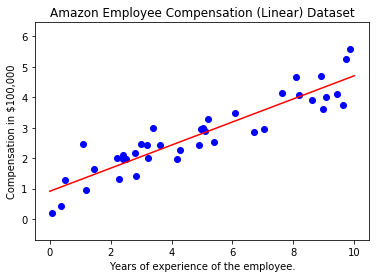

In [4]:
r.plot(data_train)

### Multi-dimensional linear regression using the analytical solution.
We can also solve the linear regression problem for multi-dimensional data, only we will get more parameters as output. Let us run the same piece of code for a 20 dimensional data and checkout the paramerter shapes. Notice how the shapes work.

In [5]:
multi_d_dataset = dataset_generator(dimensions = 20)
multi_d_train_data = multi_d_dataset.query_data(samples = 400)
multi_d_r = regressor(multi_d_train_data)
params = multi_d_r.get_params()
print("Shape of x: " + str(multi_d_train_data[0].shape))
print("Shape of Weights: " + str(params[0].shape))
print("Shape of Bias" + str(params[1].shape))

Shape of x: (400, 20)
Shape of Weights: (20, 1)
Shape of Bias(1,)


We can clearly see here that our simple model works pretty fine. Although for this simple linear model an analytical solution does exist, we find that for more complex problem structures we have to rely on some optimization procedures that are described in the later lectures.

## Ridge Regression.

We used a ``numpy.linalg.pinv`` to solve this problem. We did this because not always is $x^Tx$ invertible. What can we do in our analytical solution to make this invertible? One thing that can be done to make this solution more stable is to ensure that the diagonal elements of $w^Tw$ behave nicely. Consider the following analytical solution for $\hat{w}$,
$$\hat{w} = (X^TX + \alpha_2I)^{-1}X^Ty.$$
In this solution, you can be assured to a reasonable degree that we will give a good solution. What is this a solution for? 
Consider the error function,
$$e(w)=(y-w^Tx)^T(y-w^Tx) + \alpha_2w^Tw.$$
Now,
$$\frac{\partial e}{\partial w} = \frac{\partial}{\partial w} ( w^Tx^Txw - 2y^Txw + y^Ty + \alpha_2w^Tw),$$
$$ = 2x^Txw - 2x^Ty + 2\alpha_2I,$$
$$ = 2(x^Tx + \alpha_2I)w - 2X^Ty,$$
which, when equated to zero to obtain the minima we get,
$$(x^Tx + \alpha_2I)w = X^Ty,$$
$$\hat{w} = (X^TX + \alpha_2I)^{-1}X^Ty.$$

Fortunately, the hack we used to get a well-behaved solution turned out to be the solution for an error function where we penalize the function with the $L_2$ norm of the weights.

In [6]:
from analytical_solution import ridge_regressor
data_train = dataset.query_data(samples = 40) # Create a training dataset.  
r = ridge_regressor(data_train, alpha = 1)  # This call should return a regressor object that is fully trained.
ridge_params = r.get_params()    # This call should return parameters of the model that are 
                                 # fully trained.
data_test = dataset.query_data(samples = 40)  # Create a random testing dataset.
predictions = r.get_predictions(data_test[0]) # This call should return predictions.
print ("Rmse error of predictions = " + str(rmse(data_test[1], predictions)))

Rmse error of predictions = 0.5460028815679548


## Geometry of $L_2$ Regularization and Ridge Regression.
![Geometry of L2 Regularization](figures/regularization.png)

Consider the family of equations $w^Tw = k$. If we draw various contours of this equation, we will get concentric circles around the origin as shown in the figure. The radius of the circle is the second norm of the weight $w$. Note that we are making this plot in the space of $w$'s and not features as before. In this space, each point is a new machine. Moving along the circumference of these circles, the norm of the weights remain the same and therefore the same penalty is applied the regressor's objective. 

In this same space, consider that we are drawing various contours of $e(w)$ for varying $w$'s. We will get the contours as shown in the figure. If $e(w)$ were a third axis, projecting out from the screen, We would get a bowl. Moving along the contours of $e(w)$, the error is the same. This implies that all the machines along the circumference on these ellipeses, produce the same cumulative error, even though they might not produce the same outputs for every sample.

The legrangian form of the ridge regressor, is a constrained optimization problem that also be re-written as follows, 
$$
\min_w e(w) \text {, subject to } w^Tw < k. 
$$
If we are penalizing the machine for learning $w$'s that have a large norm, we are tying down the weights to constrin along the circumference of the $w^Tw$ curve. This implies that the learning doesn't fit perfectly to the optimal (in the context of training examples) error value. This is done in favor of thes Occam's razor that simpler models are often the best in generalizing. Occam's razor embodies one of the fundamental problems of machine learning: Bias-Variance trade-off. We want models that explain the training data well, but we don't want them to explain the training data perfectly. If we do, our models are fitting to the variance of the training data. The true explaination is probably more closer to the bias of the data which in most cases is a much simpler model. $L_2$ norm helps us enforce this in some way, therefore regularizing the machine from overfitting. 

This is not to say that $L_2$ helps avoid overfitting. In the following experiments we will demonstrate why to consider $L_2$ with a grain of salt. Consider the first of these experiments where we add to our linear data, noisy samples from another linear data. The added noise is more conplex (the slope is larger) than that of our original data. If we learn a linear regressor without regularization on this data, the more noise we add, the more the line moves towards the complex data. This happens by virtue of the cumulative Eucliedean loss that we are trying to minimize.

Rmse error of predictions with 95 samples  = 1.4092852982311275


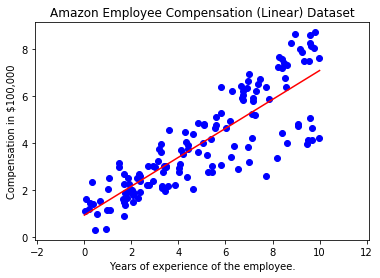

In [7]:
from time import sleep
from IPython import display
for noisy_samples in range(0,100,5):
    data_train_noisy = dataset.query_noisy_data(samples = 50, noisy_samples = noisy_samples, 
                                                noisy_params = [2*dataset.w, dataset.b])
    no_reg = regressor(data_train_noisy)  
    predictions = no_reg.get_predictions(data_test[0]) 
    print ("Rmse error of predictions with " + str(noisy_samples) +  " samples  = " + \
            str(rmse(data_test[1], predictions)))
    no_reg.plot(data_train_noisy)
    display.clear_output(wait=True)
    sleep(.2)

When using $L_2$ regularizer, we would expect the machine to not be fooled by the more complex, noise-data and rather stick with the less complex true data. In fact if we run through the space of $\alpha_2$, we will find that not only does the machine prefer a model towards the less complex data, the stronger the regularizer gets, the machine tends to prefer a model that is less complex than even the true data's manifold.

Rmse error of predictions with 4900 alpha  = 1.595647325150066


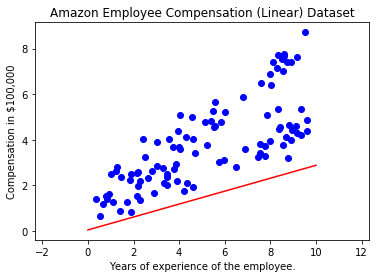

In [8]:
data_train_noisy = dataset.query_noisy_data(samples = 50, noisy_samples = 50, \
                                            noisy_params = [2*dataset.w, dataset.b])
for alpha in range (0,5000,100):
    l2_reg = ridge_regressor(data_train_noisy, alpha = alpha )
    predictions = l2_reg.get_predictions(data_test[0]) 
    print ("Rmse error of predictions with " + str(alpha) +  " alpha  = " + \
            str(rmse(data_test[1], predictions)))
    l2_reg.plot(data_train_noisy)
    display.clear_output(wait=True)
    sleep(.1)    

This is of important note. **$L_2$ regularizer prefers a less simpler model, by virtue of which we avoid overfitting to noise.** While using $L_2$, if we were not careful, we might end up with under-fitting our data. There is a very famous (probably fake) anectode about under-fitting by using a strong regularizer. Back in the day, (this anectode might actually be [this real study](http://www.cs.colostate.edu/~vision/publications/1994_fcarson_report.pdf), I am not sure) when neural networks were not yet refered to as 'deep learning' and were even less understood than they are now, a project was conceived to distinguish between trucks and tanks from images. Since the data had a lot of variability and noise, the sceinctists who built these networks used $L_2$ regularizers. The machine performed admirably in training and failed miserably during deployment. The reason was later discovered to be the fact that the machines didn't learn to classify trucks and tanks but rather to classify bright and dark images, for in the dataset, all the trucks were shot during the day and the tanks were shot during the night. The simplest explanation of the labels was brightness and not trucks and tanks. In this case, the noisy explanation (dark and light) is less complex than the real data explanation. 

Let us simulate this in our one-dimensional example. We will add noise that is less complex than the dataset and will train without regularizer. As we expect, our model will end up between the two manifolds.

Rmse error of predictions with 95 samples  = 4.3816607367992715


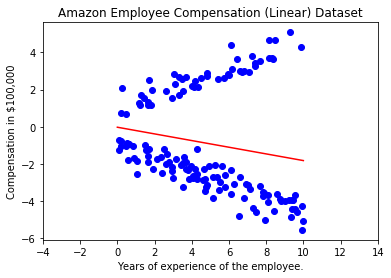

In [9]:
for noisy_samples in range(0,100,5):
    data_train_noisy = dataset.query_noisy_data(samples = 50, noisy_samples = noisy_samples)
    no_reg = regressor(data_train_noisy)  
    predictions = no_reg.get_predictions(data_test[0]) 
    print ("Rmse error of predictions with " + str(noisy_samples) +  " samples  = " + \
            str(rmse(data_test[1], predictions)))
    no_reg.plot(data_train_noisy)
    display.clear_output(wait=True)
    sleep(.2)

Let us do a similar example, but this time let us add $L_2$ regularizer and only add a few simpler noise data. We will notice that the machine immediately prefers the noise data. 

Rmse error of predictions with 4750 alpha  = 2.473215719622537


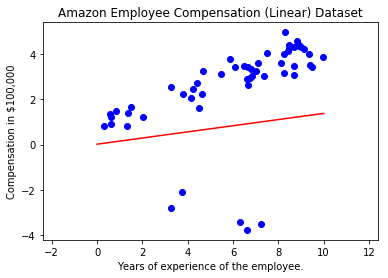

In [10]:
data_train_noisy = dataset.query_noisy_data(samples = 50, noisy_samples = 5)
for alpha in range (0,5000,250):
    l2_reg = ridge_regressor(data_train_noisy, alpha = alpha )
    predictions = l2_reg.get_predictions(data_test[0]) 
    print ("Rmse error of predictions with " + str(alpha) +  " alpha  = " + \
            str(rmse(data_test[1], predictions)))
    l2_reg.plot(data_train_noisy)
    display.clear_output(wait=True)
    sleep(.1)    

## Lasso Regression.

In $L_2$ regularization we penalized the network for learning longer length vectors. Another way to regularize is to penalize the network for learning non-zero weights. We can achieve this by using the following constrained optimization problem:
$$
\min_w e(w) \text {, subject to } \vert w\vert < k, 
$$
or alternatively, minimizing the following error function,
$$e(w)=(y-w^Tx)^T(y-w^Tx) + \alpha_1 \vert w \vert.$$
Weights in this formulation independently decay to zero. After training, this will imply that some components of the weight vector are literally zero. This implies that the feature dimensions (of $x$) corresponding to those weights are immaterial and don't even have to be extracted. Ergo, $L_1$ regularizer induces sparsity in weights and indirectly performs feature selection. 

### Geometry of the $L_1$ Regularizer.
![Geometry of L1 Regularization](figures/l1_reg.png)
Consider the family of equations $\vert w \vert = k$. If we draw various contours of this equation, we will get concentric diamonds around the origin as shown in the figure. The length of the diamonds is the first norm of the weight $w$. Note that we are making this plot in the space of $w$'s as before. In this space, each point is a new machine. Moving along the circumference of these squares, the norm of the weights remain the same and therefore the same penalty is applied the regressor's objective. 

In this same space, consider that we are drawing various contours of $e(w)$ for varying $w$'s. We will get the contours as shown in the figure. If we are penalizing the machine for learning $w$'s that have a large first norm, we are penalizing the machine to learn weights that are greater than $0$. This implies that the learning doesn't fit perfectly to the optimal (in the context of training examples) error value. This strongly assumes Occam's razor. This also works as a way of filtering out dimensions of the data that are confusing and noisy. If some dimensions of data are not directly (in the context of the error) related to the variate, this regularizer will avoid using information from those dimensions in explaining the data. 

$L_1$ induces sparsity in the machine. Sparsity means that the weight matrix $w$ is sparse, implying less non-zero values. This is advantageous in many ways. Sparse matrices are more memory efficient and a well-implemented sparse math library is much faster.

# Gradient Descent.
![Error bowl](figures/error_bowl.png)

There are cases where we might not be able to learn by using the analytical function. While regularization can solve some of these problems, they don't always. In these cases, we have gradient descent coming to our rescue. Consider the error function, it is a bowl. If we initialize a machine with some random weights, it will be a point in this bowl.

## Batch Gradient Descent.
Now consider the gradient at that point. 
$$\frac{\partial e}{\partial w} = X^T(XW- y) + \alpha_2 W^TW$$
If we travel from this point in the direction opposite to that of $\frac{\partial e}{\partial w}$, we should hopefully find the shortest path down to the bottom of this bowl function. The step in the direction of this gradient that we want to take, is usually called the learning rate $\eta$. Taking this step is mathematically written down as,
$$ W^{\tau + 1} = W^\tau - \eta \frac{\partial e}{\partial W}. $$
At convergence ($\tau_c$ steps later), we can expect that the $W^{\tau_c} \approx \hat{W}$. This is an iterative way of arriving at a solution and is called the gradient descent. 

Gradient descent is implemented in these [lines of code](gradient_descent_solution.py#L48-L58). The crux of the code is as follows:
```python
prev_cost = 10
curr_cost = self.get_cost(x,y,w)
num_iters = 10000
iter = 0
while prev_cost - curr_cost > 0.00000001:

    gradient = ((x.T).dot(x.dot(w)-y) + beta*w.T.dot(w))/y.shape[0]
    w = w - alpha*gradient
    prev_cost = curr_cost
    curr_cost = self.get_cost(x, y, w)
    iter += 1
    if iter > num_iters:
        break   
```

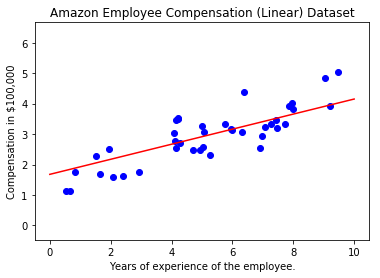

In [24]:
from gradient_descent_solution import gd
data_train = dataset.query_data(samples = 40)   
r = gd(data_train, k = 1)  # This will plot after a few iterations. It will also cross-validate
params = r.get_params()
r.plot(data = data_train)

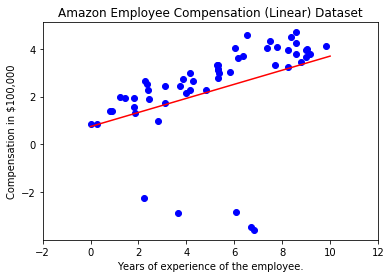

In [25]:
data_train_noisy = dataset.query_noisy_data(samples = 50, noisy_samples = 5)
r = gd(data_train_noisy, k = 1) 
params = r.get_params()
r.plot(data = data_train_noisy)

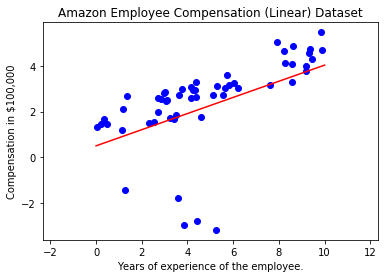

In [26]:
data_train_noisy = dataset.query_noisy_data(samples = 50, noisy_samples = 5)
r = gd(data_train_noisy, k = 1)  
params = r.get_params()
r.plot(data = data_train_noisy)

The gradient descent that is used here is commonly refered to as a the batch gradient descent. This is because we process the data in as a whole. We calculate the gradients for the whole dataset to perform just one update on the model. This method is often very slow.
It is clearly intractable for datasets that don't fit in memory. We also lose the ability to perform online learnability. On the other hand, the 
gradients are trust workth and optimal, so learning rate can be large. 

## Stochastic Gradient Descent

Consider the following gradient update rule:

$$ w^{n \tau +i} = w^{n \tau + i -1} - \eta^{n \tau +i-1} e'(w^{n \tau + i -1}) $$

$$ e'(w^{n\tau + i -1}) = -2x_i^Ty_i + 2 x^T_ix_iw^{n\tau + i -1 } $$

In this setup, we calculate the gradients for data one-by-one to perform one descent update per sample.
This system is faster and onl need to load memory for one sample at a time, so it is memory efficient. 
On the other hand gradients are noisy, so the descent wanders the space. This can be both helpful and unhelpful depending on the surface. Gradients are highly untrustworthy and noisy so it is better have a small learning rate.
This technique is called stochastic gradient descent. 

### Stochastic Mini-Batch Gradient Descent

Minibatch gradient descent is in between stochastic and online gradient descent. Here we run more than one sample per update but not the entire dataset. The size of a mini-batch is up for debate and is often a hyperparameter. 

## Cross-Validation
![Error bowl](figures/cross-validation.png)

In larger models, there might not be just one global minima, but several local minima. Even in cases where there is only one local minima, due to the step size, we can't guarantee that we will exactly reach the optimum. In these cases, cross-validation helps us acheive general results. In cross-validation, we divide the dataset into several parts. We get one model per fold and we can then average the models to get the final model.